In [ ]:
import pandas as pd
import os
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import metrics
import skforecast
from sklearn.ensemble import RandomForestRegressor 
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error,mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.exceptions import LongTrainingWarning
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Modelado SARIMAX
import warnings

In [ ]:
base_dir = os.getcwd()
ruta_path = os.path.join(
    base_dir, "..","..", "data", "homogeneized","Alcala_Henares", "datos_Alcala_Henares_homogenizados.csv"
)
df = pd.read_csv(ruta_path)

In [3]:
df.dtypes

fecha        object
tmed        float64
tmin        float64
tmax        float64
velmedia    float64
hrMedia     float64
dtype: object

In [4]:
# Separo la fecha en las columnas año, mes y dia 
df[["año","mes","dia"]] = df["fecha"].str.split("-", expand=True).astype(int)

### AÑADIENDO VARIABLES EXÓGENAS

In [5]:
# Creo una nueva columna que dependiendo del mes en el que se encuentre corresponderá a una estación u otra
for i, mes in enumerate(df["mes"]):
    if mes in [12, 1, 2]:
        df.loc[i, "estacion"] = "Invierno"
    elif mes in [3, 4, 5]:
        df.loc[i, "estacion"] = "Primavera"
    elif mes in [6, 7, 8]:
        df.loc[i, "estacion"] = "Verano"
    else:
        df.loc[i, "estacion"] = "Otoño"
        

In [6]:
# Get dummies de la columna estación para convertirlo a numérico
df_encoded = pd.get_dummies(df["estacion"], dtype = int, drop_first=True)

In [7]:
# Meto las columnas en el dataframe original
df[["Otoño","Primavera","Verano"]] = df_encoded

In [8]:
# Funcion seno coseno para hacer las variables mes y dia cíclicas
df["MONTH_SIN"] = np.sin(2 * np.pi * df["mes"] / 12)
df["MONTH_COS"] = np.cos(2 * np.pi * df["mes"] / 12)
df["DAY_SIN"] = np.sin(2 * np.pi * df["dia"] / 365)
df["DAY_COS"] = np.cos(2 * np.pi * df["dia"] / 365)

## PREDICCIÓN DIARIA
- Predicción 1 día: 
    - Temperatura media
    - Temperatura máxima
    - Temperatura mínima
    - Humedad relativa media
- Predicción 7 días: 
    - Temperatura media
    - Temperatura máxima


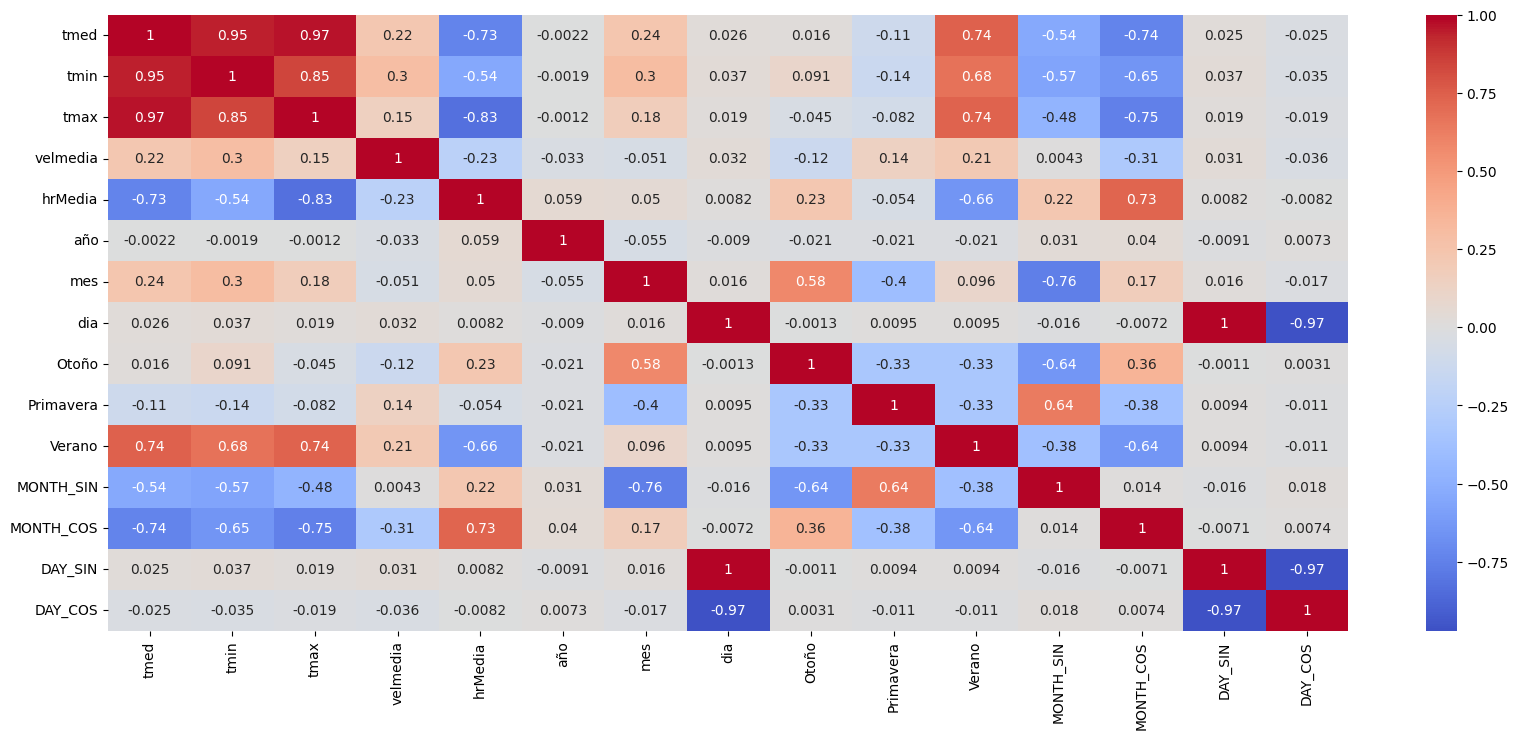

In [9]:
# Se puede observar que para predecir la temperatura media el mes tiene importancia
plt.figure(figsize=(20, 8))
correlation_matrix = df.corr(numeric_only=True)

# Crear un mapa de calor para visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

In [10]:
# Calcula la media de la temperatura media por grupo ("mes" y "dia") y asigna el resultado a una nueva columna
df["temp_med_dia_mes"] = df.groupby(["mes", "dia"])["tmed"].transform("mean")
# Calcula la media de temperatura máxima por grupo ("mes" y "dia") y asigna el resultado a una nueva columna
df["temp_med_max_dia_mes"] = df.groupby(["mes", "dia"])["tmax"].transform("mean")
# Calcula la media de temperatura mínima por grupo ("mes" y "dia") y asigna el resultado a una nueva columna
df["temp_med_min_dia_mes"] = df.groupby(["mes", "dia"])["tmin"].transform("mean")
# Calcula la media de humedad media por grupo ("mes" y "dia") y asigna el resultado a una nueva columna
df["hr_med_dia_mes"] = df.groupby(["mes", "dia"])["hrMedia"].transform("mean")

In [11]:
# Creo los distintos dataframes que se usarán para las predicciones de la temperatura media, temperatura máxima, temperatura mínima y humedad relativa media
df_temp_med = df.drop(columns=['fecha', 'tmin', 'tmax','temp_med_max_dia_mes','temp_med_min_dia_mes','hr_med_dia_mes', 'velmedia', 'hrMedia', 'año','mes','dia','estacion'])
df_temp_max_med = df.drop(columns=['fecha', 'tmed','tmin','temp_med_dia_mes','temp_med_min_dia_mes','hr_med_dia_mes', 'velmedia', 'hrMedia', 'año','mes','dia','estacion'])
df_temp_min_med = df.drop(columns=['fecha', 'tmed','tmax','temp_med_dia_mes','temp_med_max_dia_mes','hr_med_dia_mes', 'velmedia', 'hrMedia', 'año','mes','dia','estacion'])
df_hr_med = df.drop(columns=['fecha', 'tmed','tmin','tmax','temp_med_dia_mes','temp_med_min_dia_mes','temp_med_max_dia_mes', 'velmedia', 'año','mes','dia','estacion'])

In [12]:
# cojo la información de las columnas exógenas de los 7 dias de febrero que voy a tener que predecir
# Es la misma información que tendrían los días que voy a predecir porque es la misma estación, mismas fechas y misma media de temperatura
fechas_a_predecir = df.loc[(df["fecha"]>= '2019-02-11') & (df["fecha"]<= '2019-02-17')]

temp_media_dia_mes = fechas_a_predecir["temp_med_dia_mes"].to_list()
temp_med_max_dia_mes = fechas_a_predecir["temp_med_max_dia_mes"].to_list()
temp_med_min_dia_mes = fechas_a_predecir["temp_med_min_dia_mes"].to_list()
hr_med_dia_mes = fechas_a_predecir["hr_med_dia_mes"].to_list()
otonio = fechas_a_predecir["Otoño"].to_list()
primavera = fechas_a_predecir["Primavera"].to_list()
verano = fechas_a_predecir["Verano"].to_list()
lista_mes_seno = fechas_a_predecir["MONTH_SIN"].to_list()
lista_mes_coseno = fechas_a_predecir["MONTH_COS"].to_list()
lista_dia_seno = fechas_a_predecir["DAY_SIN"].to_list()
lista_dia_coseno = fechas_a_predecir["DAY_COS"].to_list()


dic = {"temp_med_dia_mes":temp_media_dia_mes
       ,"temp_med_max_dia_mes":temp_med_max_dia_mes
       ,"temp_med_min_dia_mes":temp_med_min_dia_mes
       ,"hr_med_dia_mes":hr_med_dia_mes
       ,"Otoño":otonio
       ,"Primavera":primavera
       ,"Verano":verano
       ,"MONTH_SIN":lista_mes_seno
       ,"MONTH_COS":lista_mes_coseno
       ,"DAY_SIN":lista_dia_seno
       ,"DAY_COS":lista_dia_coseno}

df_predicciones = pd.DataFrame(dic)

# Cojo el ultimo indice del dataframe original y reescribo el nuevo para que parezca que es la continuación del anterior
# Lo hago porque al aplicar el modelo recursive, al coger steps tienen que tener un indice seguido.
inicio = df.shape[0]
df_predicciones.index= [i for i in range(inicio, inicio + 7)]

# df para la predicción del dia siguiente
df_predicciones_1_dia = df_predicciones.head(1)


## MODELOS
- **REGRESIÓN LINEAL RIDGE:** 
    - Es una variante de la regresión lineal que se utiliza para manejar problemas de multicolinealidad (cuando las variables predictoras están altamente   correlacionadas entre sí). 
    - A diferencia de la regresión lineal tradicional, Ridge introduce un término de regularización que penaliza los coeficientes del modelo para evitar que tomen valores extremos, es decir, reduce el overfitting.
- **SKFORECAST RECURSIVE:**
    - Skforecast es una librería de Python diseñada para facilitar la creación de modelos de pronóstico (forecasting) utilizando técnicas de aprendizaje automático. 
    - El enfoque Recursive es una estrategia para hacer predicciones multi-paso (multi-step forecasting) en series temporales.
    - En lugar de entrenar un modelo separado para cada paso de predicción, se entrena un único modelo que se utiliza de manera recursiva.
    - En cada paso, la predicción anterior se usa como entrada para predecir el siguiente valor.
- **XGBOOST REGRESSOR:**
    - Combina múltiples modelos débiles de árboles de regresión para crear un modelo más potente.
    - Cada árbol intenta corregir los errores del anterior.
    - Al igual que el modelo Ridge, incluye un término de regularización para reducir el overfitting.
- **RANDOM FOREST REGRESSOR:**
    - Combina múltiples árboles de regresión para crear un modelo más robusto.
- **SARIMAX:**
    - SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) combina varios componentes:
        - Componente (AR): relaciona el valor actual con valores pasados (lags).
        - Componente media móvil (MA): asume que el error de predicción es una combinación lineal de los errores de predicción pasados.
        - Componente integrado (I) indica que los valores de la serie original han sido reemplazados por la diferencia entre valores consecutivos
    - Además de lo dicho previamente, se pueden añadir patrones estacionales y variables exógenas

### TEMPERATURA MEDIA

In [13]:
df_temp_med.head(2)

,tmed,Otoño,Primavera,Verano,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,temp_med_dia_mes
0,5.3,0,0,0,0.5,0.866025,0.017213,0.999852,6.428571
1,4.6,0,0,0,0.5,0.866025,0.034422,0.999407,5.400000


In [14]:
df_temp_med.columns

Index(['tmed', 'Otoño', 'Primavera', 'Verano', 'MONTH_SIN', 'MONTH_COS',
       'DAY_SIN', 'DAY_COS', 'temp_med_dia_mes'],
      dtype='object')

## FORECASTER RECURSIVE

In [15]:
# Datos de entrenamiento y test
train_size = int(len(df_temp_med)*0.9)

data_train = df_temp_med.iloc[:train_size]
data_test = df_temp_med.iloc[train_size:]


### Predicción 1 día

### RIDGE RECURSIVE

In [16]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = Ridge(random_state=2517),
                 lags      = 6
             )
forecaster.fit(y=data_train['tmed'], exog = data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=1, exog = data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

# Para saber cuantos steps coger, cojo 1 step
y_buena = df_temp_med[2009:2010]
y_buena = y_buena["tmed"]


rmse =  root_mean_squared_error(y_buena, predictions)
rmse

0.44348310518996925

### Resultados

In [17]:
# Entreno el algoritmo con todos los datos disponibles
forecaster.fit(y=df_temp_med['tmed'], exog = df_temp_med[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

# Hago una prediccion con los datos del día que quiero predecir
predictions = forecaster.predict(steps=1, exog = df_predicciones_1_dia[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

predictions

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1292: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


2233    9.761566
Name: pred, dtype: float64

## SARIMAX (Predicción de 7 días)

### prueba de predecir todos los valores de test(224)

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                              tmed   No. Observations:                 2009
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -3833.307
Date:                           Fri, 07 Mar 2025   AIC                           7694.614
Time:                                   21:17:22   BIC                           7773.089
Sample:                                        0   HQIC                          7723.422
                                          - 2009                                         
Covariance Type:                             opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.0134      1.623      0.008      0.993      -3.168       3.195
temp_med_dia_mes     0.98

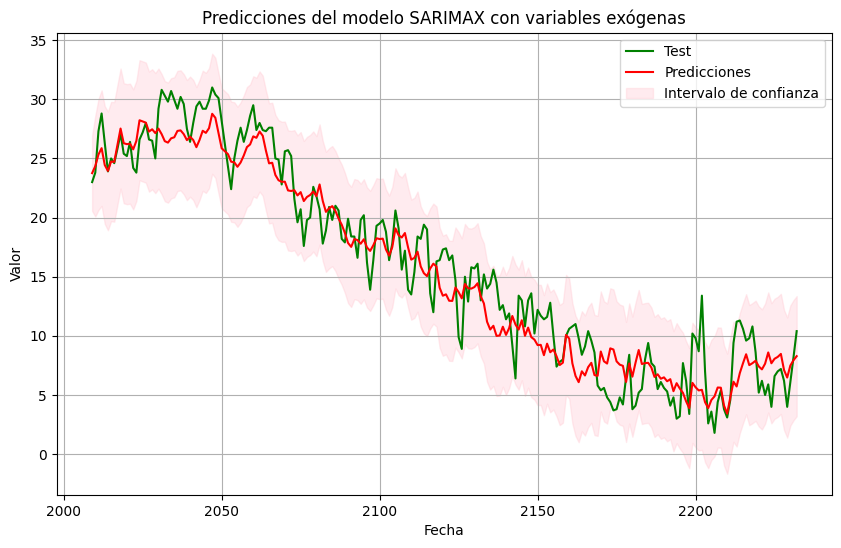

In [18]:

model = SARIMAX(
    data_train["tmed"],
    exog=data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano', 'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS']],  # Variables exógenas
    order=(1, 0, 1),  # Parámetros (p, d, q) del modelo ARIMA
    seasonal_order=(1, 0, 1, 7),  # Parámetros estacionales (P, D, Q, m)
    trend='c',  # constante (tendencia)
)

results = model.fit(disp=False)

print(results.summary())

preds = results.get_forecast(
    steps=len(data_test["tmed"]),  # Número de períodos a predecir(224)
    exog=data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano', 'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS']],  
)

predicted_values = preds.predicted_mean
conf_int = preds.conf_int()


plt.figure(figsize=(10, 6))
plt.plot(data_test.index, data_test["tmed"], label="Test", color="green")
plt.plot(data_test.index, predicted_values, label="Predicciones", color="red")
plt.fill_between(
    data_test.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color="pink",
    alpha=0.3,
    label="Intervalo de confianza",
)
plt.title("Predicciones del modelo SARIMAX con variables exógenas")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid()
plt.show()

In [19]:
# RMSE del modelo anterior
rmse = root_mean_squared_error(data_test["tmed"], predicted_values)
rmse

2.3881836485348136

In [20]:
# Prueba de predecir 7 ultimos registros


y_prueba = data_test[0:7]["tmed"]
x_prueba = data_test[0:7]


preds = results.get_forecast(
    steps=len(y_prueba),  # Número de períodos a predecir
    exog=x_prueba[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano', 'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS']],  # Variables exógenas para el conjunto de test
)
predicted_values = preds.predicted_mean

In [21]:
# RMSE del modelo pero esta vez con 7 valores de test
rmse = root_mean_squared_error(y_prueba, predicted_values)
rmse

1.5529609013239003

### Modelo para la predicción de 7 días

In [22]:
# Ahora entreno con todos los registros disponibles
model = SARIMAX(
    df_temp_med["tmed"],
    exog=df_temp_med[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano', 'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS']],  # Variables exógenas
    order=(1, 0, 1),  # Parámetros (p, d, q) del modelo ARIMA
    seasonal_order=(1, 0, 1, 7),  # Parámetros estacionales (P, D, Q, m)
    trend='c',  # constante (tendencia)
)

results = model.fit(disp=False)


preds = results.get_forecast(
    steps=len(df_predicciones),  # Número de períodos a predecir(7)
    exog=df_predicciones[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano', 'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS']],  
)

predicted_values = preds.predicted_mean
conf_int = preds.conf_int()

predicted_values

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2233     9.024986
2234    10.037884
2235     9.668015
2236     8.952886
2237     8.696633
2238     9.026150
2239     9.120166
Name: predicted_mean, dtype: float64

### Generando un dataframe para las visualizaciones

In [ ]:

fechas = pd.date_range("2025-02-11","2025-02-17")
df_provisional = pd.DataFrame(predicted_values)
df_provisional["fecha"] = fechas
df_provisional["predicted_mean"] = round(df_provisional["predicted_mean"],2)
df_provisional["predicted_mean"] = df_provisional["predicted_mean"].astype(str).replace(".",",")

base_dir = os.getcwd()
ruta_path = os.path.join(
    base_dir, "..", "data", "predicted","Alcala_Henares", "predicción_temp_med.csv"
)

df_provisional.to_csv(ruta_path, sep=";", index=False)

## TEMPERATURA MÁXIMA

In [24]:
df_temp_max_med.head(1)

,tmax,Otoño,Primavera,Verano,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,temp_med_max_dia_mes
0,14.7,0,0,0,0.5,0.866025,0.017213,0.999852,13.421429


### FORECASTER RECURSIVE

In [25]:
# Datos de entrenamiento y test
train_size = int(len(df_temp_max_med)*0.9)

data_train = df_temp_max_med.iloc[:train_size]
data_test = df_temp_max_med.iloc[train_size:]


### Predicción 1 día

### RIDGE RECURSIVE

In [26]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = Ridge(random_state=2517),
                 lags      = 6
             )
forecaster.fit(y=data_train['tmax'], exog = data_train[['temp_med_max_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=1, exog = data_test[['temp_med_max_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

# Para saber cuantos steps coger, cojo 1 step
y_buena = df_temp_max_med[2009:2010]
y_buena = y_buena["tmax"]

rmse =  root_mean_squared_error(y_buena, predictions)
rmse

0.2394539514698053

### Resultados

In [27]:
# Aplico el modelo anterior pero esta vez con todos los datos disponibles
forecaster.fit(y=df_temp_max_med['tmax'], exog = df_temp_max_med[['temp_med_max_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=1, exog = df_predicciones_1_dia[['temp_med_max_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

predictions

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1292: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


2233    14.854724
Name: pred, dtype: float64

### Predicción 7 días

### RANDOM FOREST RECURSIVE

In [28]:

# Hiperparámetros para que encuentre el mejor
param_grid = {
    'n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 50, 80, 100],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'min_samples_split': [2, 3, 4, 5],
    'max_depth': [2, 3, 4, 5]
}

# Modelo
regr = RandomForestRegressor(random_state=2517)

# Métrica RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Este tipo de división no me mezcla las fechas, es decir, no hay data leakage
tscv = TimeSeriesSplit(n_splits=5)  # 5 divisiones temporales

grid_search = GridSearchCV(
    estimator=regr,
    param_grid=param_grid,
    scoring=rmse_scorer,  
    cv=tscv, 
    n_jobs=-1 
)

grid_search.fit(data_train[['temp_med_max_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']], data_train[['tmax']])

# Mejores hiperparámetros y RMSE
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor RMSE:", np.sqrt(-grid_search.best_score_))  # Convertir a RMSE

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mejores hiperparámetros: {'criterion': 'absolute_error', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 80}
Mejor RMSE: 1.9397653290480275


### Resultados

In [29]:
# Predicciones para 7 dias
grid_search.fit(df_temp_max_med[['temp_med_max_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']],df_temp_max_med["tmax"])
p = grid_search.predict(df_predicciones[['temp_med_max_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])
p

array([13.2740625, 14.124375 , 15.7053125, 16.1440625, 16.3928125,
       17.1821875, 17.3053125])

### Generando un dataframe para las visualizaciones

In [30]:
df_provisional["tmax"] = p

df_provisional["tmax"] = round(df_provisional["tmax"],2)
df_provisional["tmax"] = df_provisional["tmax"].astype(str).replace(".",",")

## TEMPERATURA MÍNIMA

In [31]:
df_temp_min_med.head(1)

,tmin,Otoño,Primavera,Verano,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,temp_med_min_dia_mes
0,-4.1,0,0,0,0.5,0.866025,0.017213,0.999852,-0.685714


In [32]:
# Datos de entrenamiento y test
train_size = int(len(df_temp_min_med)*0.9)

data_train = df_temp_min_med.iloc[:train_size]
data_test = df_temp_min_med.iloc[train_size:]


### Predicción 1 día

### Random Forest

In [33]:
# Hiperparámetros 
param_grid = {
    'n_estimators': [100],
    'criterion': ['squared_error'],
    'min_samples_split': [2],
    'max_depth': [3]
}

# Modelo
regr = RandomForestRegressor(random_state=2517)

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

tscv = TimeSeriesSplit(n_splits=5)  # 5 divisiones temporales

grid_search = GridSearchCV(
    estimator=regr,
    param_grid=param_grid,
    scoring=rmse_scorer,  
    cv=tscv,
    n_jobs=-1  
)


grid_search.fit(data_train[['temp_med_min_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']], data_train["tmin"])

# Mejores hiperparámetros y RMSE
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor RMSE:", np.sqrt(-grid_search.best_score_))  # Convertir a RMSE

Mejores hiperparámetros: {'criterion': 'squared_error', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Mejor RMSE: 1.8568766900353224


### Resultados

In [34]:
# Predicciones para tmin en 1 dia
grid_search.fit(df_temp_min_med[['temp_med_min_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']], df_temp_min_med["tmin"])
p = grid_search.predict(df_predicciones_1_dia[['temp_med_min_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])
p

array([1.52883734])

### Generando un dataframe para las visualizaciones

In [ ]:
df_provisional["tmin"] = [p[0], "null","null","null","null","null","null"]

df_provisional["tmin"] = round(df_provisional["tmin"],1)
df_provisional["tmin"] = df_provisional["tmin"].astype(str).replace(".",",")

### HUMEDAD RELATIVA MEDIA

In [38]:
df_hr_med.head(1)


,hrMedia,Otoño,Primavera,Verano,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,hr_med_dia_mes
0,62.0,0,0,0,0.5,0.866025,0.017213,0.999852,72.285714


In [39]:
# Datos de entrenamiento y test
train_size = int(len(df_hr_med)*0.9)

data_train = df_hr_med.iloc[:train_size]
data_test = df_hr_med.iloc[train_size:]

### Predicción 1 día

### RECURSIVE XGBOOST

In [40]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = xgb.XGBRegressor(random_state=2517),
                 lags      = 6
             )
forecaster.fit(y=data_train['hrMedia'], exog = data_train[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=1, exog = data_test[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

# Para saber cuantos steps coger, cojo 1 step
y_buena = df_hr_med[2009:2010]
y_buena = y_buena["hrMedia"]

rmse =  root_mean_squared_error(y_buena, predictions)
rmse

0.30401611328125

### Resultados


In [41]:
# Entreno el anterior modelo pero con todos los registros disponibles
forecaster.fit(y=df_hr_med['hrMedia'], exog = df_hr_med[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])

# Hago una prediccion para todos los valores de test
p = forecaster.predict(steps=1, exog = df_predicciones_1_dia[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS']])
p

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1292: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


2233    75.01017
Name: pred, dtype: float64

### Generando un dataframe para las visualizaciones

In [ ]:
df_provisional["hrMedia"] = [p.values[0],"null","null","null","null","null","null"]

df_provisional["hrMedia"] = round(df_provisional["hrMedia"],2)
df_provisional["hrMedia"] = df_provisional["hrMedia"].astype(str).replace(".",",")

base_dir = os.getcwd()
ruta_path = os.path.join(
    base_dir, "..", "data", "predicted","Alcala_Henares", "predicciónes.csv"
)

df_provisional.to_csv(ruta_path, sep=";", index=False)